# Fig. 7 - Retrieved 1D versus longitude and line contrast
This Jupyter notebooks reproduces Figure 7. The output .png and .pdf files are saved in <em>/figures</em>. Comparison of the GCM P-T profiles and the 1D retrieved P-T profile to show we are more sensitive to the westward sides of the exoplanet’s disk, which have the strongest inversions in the spectral line-forming region

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import matplotlib.gridspec as gridspec
from matplotlib import colormaps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll

Input directory for GCM output and elemental abundances.

In [2]:
dirin = '../data/gcm/'
dirout = '../figures/'
gcm_input_fname = 'W76b0GPF.txt'
gcm_input_file = os.path.join(dirin, gcm_input_fname)

Define some functions used to plot the profiles.

In [3]:
def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def load_pt_3d(gcm_input_file):
    """Load GCM 3D P-T profile."""
    data = np.loadtxt(gcm_input_file, skiprows=6)

    longs = data[:,1]
    lats = data[:,0]
    longs = np.unique(longs)
    lats = np.unique(lats)

    pt_3d = {}
    for a, lon in enumerate(longs):
        for b, lat in enumerate(lats):
            i = np.where(np.logical_and(data[:,1] == lon, data[:,0] == lat))[0]
            P = data[i,4] 
            T = data[i,5]
            pt_3d[f'({np.round(lon,1)}, {np.round(lat,1)})'] = (P, T)
    
    return np.round(longs,1), np.round(lats,1), pt_3d

def plot_pt_3d(longs, lats, pt_3d, spacing=4):
    """Plot 3D P-T profile."""
    fig, ax = plt.subplots()
    for a, lon in enumerate(longs[::spacing]):
        for b, lat in enumerate(lats[::spacing]):
            P, T = pt_3d[f'({lon}, {lat})']
            plt.plot(T, P)
    plt.yscale('log')
    plt.ylim(1e2, 1e-5)
    return fig, ax

def load_eos(eos_input_file):
    """Load eos."""
    #reading in the chemistry file
    columns2 = ['T','P','el','H','H2','He','C2H2',
               'CH4','CO','CO2','H2O','H2S','HCN',
               'K','Na','NH3','PH3','TIO','VO',
               'Fe', 'Fe+', 'Mg', 'Ca', 'Ti', 'Ti+',
               'V', 'C', 'Cr', 'Ni','Mn','Ca+','Li', 'OH']

    df2 = pd.read_csv(eos_input_file, names=columns2,skiprows=1,delim_whitespace=True).dropna()

    """Load equilibrium chemistry VMR values."""
    #makind some arrays to hold values for each pressure (28) and temperature (46)
    eosH2Ovals=np.zeros((28,46))
    eosCOvals=np.zeros((28,46))
    #eosOHvals=np.zeros((28,46))

    tempvalues=np.linspace(500,5000,num=46,endpoint=True) #grid of temperature values
    pressures=[1.00000000e-06, 2.15443452e-06, 4.64158919e-06, 1.00000000e-05,
     2.15443452e-05, 4.64158919e-05, 1.00000000e-04, 2.15443304e-04,
     4.64159240e-04, 1.00000000e-03, 2.15443304e-03, 4.64159240e-03,
     1.00000000e-02, 2.15443304e-02, 4.64159240e-02, 1.00000000e-01,
     2.15443304e-01, 4.64159240e-01, 1.00000000e+00, 2.15443304e+00,
     4.64159240e+00, 1.00000000e+01, 2.15443304e+01, 4.64159240e+01,
     1.00000000e+02, 2.15443304e+02, 4.64159240e+02, 1.00000000e+03] #grid of pressure values

    tempcount=0
    presscount=0
    for i in range(1288):
        if tempcount < 46 and presscount < 28:
            eosH2Ovals[presscount,tempcount]=df2['H2O'].iloc[i]
            eosCOvals[presscount,tempcount]=df2['CO'].iloc[i]
            tempcount=tempcount+1
        elif presscount < 28:
            tempcount=0
            presscount=presscount+1
            eosH2Ovals[presscount,tempcount]=df2['H2O'].iloc[i]
            eosCOvals[presscount,tempcount]=df2['CO'].iloc[i]
            tempcount=tempcount+1

    #need to reverse the temperature values to match the order of the opacity files
    #and then reverse the pressure order 
    for j in range(28):
        eosH2Ovals[j,:]=eosH2Ovals[j,::-1]
        eosCOvals[j,:]=eosCOvals[j,::-1]
        #eosOHvals[j,:]=eosOHvals[j,::-1]
    for p in range(46):
        eosH2Ovals[:,p]=eosH2Ovals[::-1,p]
        eosCOvals[:,p]=eosCOvals[::-1,p]
        
    return tempvalues, pressures, eosCOvals, eosH2Ovals

Load P-T profile.

In [4]:
longs, lats, pt_3d = load_pt_3d(gcm_input_file)
# fig, ax = plot_pt_3d(longs, lats, pt_3d, spacing=2)
# plt.show()
nlon, nlat = len(longs), len(lats)
nP = 100
P = 10**np.linspace(-6, 2, nP)
T = np.zeros(shape=(nlon, nlat, nP))
for a, lon in enumerate(longs):
    for b, lat in enumerate(lats):
        pressure, temperature = pt_3d[f'({lon}, {lat})']
        T[a,b,:] = np.interp(x=P, xp=pressure, fp=temperature)
interp_T = RegularGridInterpolator((longs, lats, P), T, bounds_error=False)

Load elemental abundances.

In [5]:
eos_input_fname = 'eos_solar_gas_full_hires.dat'
eos_input_file = os.path.join(dirin, eos_input_fname)

T_eos, P_eos, eosCOvals, eosH2Ovals = load_eos(eos_input_file)

interp_eos_CO = RegularGridInterpolator((T_eos, P_eos), np.log10(eosCOvals.T), bounds_error=False)
interp_eos_H2O = RegularGridInterpolator((T_eos, P_eos), np.log10(eosH2Ovals.T))

Function to plot P-T and chemical profiles.

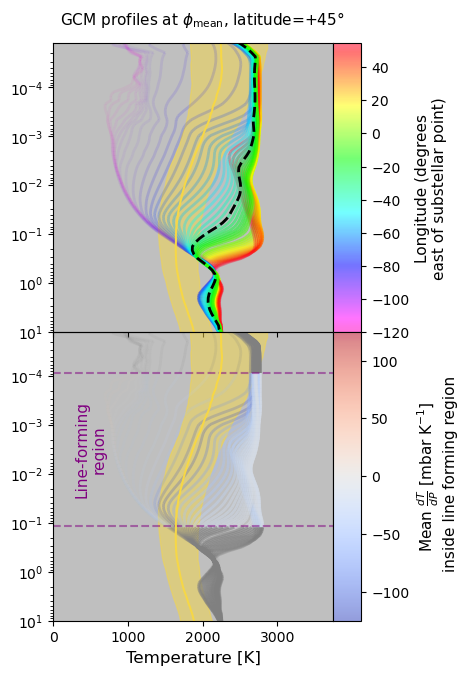

In [9]:
def plot_pt_chemistry(pressure, lats, phase, lat = 0., lf_region=(0.5e-3,7.5e-3), phase_precision=2, lat_precision=1):
    """Plot P-T chemistry."""
    cmap = colormaps['inferno']
    c1 = cmap(0.1)
    c2 = cmap(0.9)
    
    cmap_lon = colormaps['gist_rainbow_r']
    cmap_lon.set_bad('gray')
    cmap_gradient=colormaps['coolwarm']
    cmap_gradient.set_bad('gray')
    
    fig = plt.figure(figsize=(5./1.68 + 1,7.5))
    gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[1.,0.1], height_ratios=[1,1], wspace=0.,hspace=0.0)
    ax = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[1,0])
    cax = fig.add_subplot(gs[0,1])
    cax2 = fig.add_subplot(gs[1,1])

    is_dayside = lambda l: l <= 90. or l >= 270.
    rot = phase - 180.
    
    longs_grid = np.linspace(0, 360, 100)
    longs_masked = longs_grid[
        np.logical_or((longs_grid + rot)%360<90., (longs_grid + rot)%360>270.)
    ]
    first_day = True
    first_night = True
    profiles = np.zeros(shape=(len(pressure), len(longs_masked), 3)) * np.nan
    segments_all = []
    pressure_all = []
    alpha_geo_all = []
    dlogP_dT_all = []
    lon_phase = (180-phase)
    lon_dist = (longs_masked + 180)%360 - 180
    lon_closest = longs_masked[np.argmin(np.abs(lon_dist - lon_phase))]
    lmin, lmax = np.min(lon_dist), np.max(lon_dist)
    for lon_i, lon in enumerate(longs_masked):
        try:
            if lat == 0.:
                geometric_factor = np.cos(lon/180.*np.pi)
            if lat == 45.:
                geometric_factor = 0.5 * np.cos(lon/180.*np.pi)
            
            lon_dist = (lon + 180)%360 - 180
            temperature = interp_T((lon, lat, pressure))
            abundance_CO = np.array([interp_eos_CO((t,p)) for (t,p) in zip(temperature,pressure)])
            abundance_H2O = np.array([interp_eos_H2O((t,p)) for (t,p) in zip(temperature,pressure)])
            segments = make_segments(temperature, pressure)
            values = np.array([lon_dist for i in range(len(temperature))])
            if lon == lon_closest:
                temperature_closest = temperature
                pressure_closest = pressure
                
            alpha_geo = min(max(geometric_factor+0.05, 0.05), 1.)
            lc1 = mcoll.LineCollection(segments, array=values, norm=plt.Normalize(lmin, lmax), cmap=cmap_lon,
                                      linewidth=2, alpha=alpha_geo)
            ax.add_collection(lc1)

            dlogP_dT = np.diff(temperature)/np.diff(pressure*1e3)
            line_forming_region = np.logical_and(pressure[0]+np.diff(pressure) >= lf_region[0], pressure[0]+np.diff(pressure) <= lf_region[1])
            dlogP_dT_mean = np.mean(dlogP_dT[line_forming_region])
            segments = make_segments(temperature, pressure)
            pressure_all.append(pressure)
            segments_all.append(segments)
            alpha_geo_all.append(alpha_geo)
            dlogP_dT_all.append(dlogP_dT_mean)
        except:
            pass
        
    ax.plot(temperature_closest, pressure_closest, lw=2, color='k', ls='--')
    
    for segments, v, pressure, ag in zip(segments_all, dlogP_dT_all, pressure_all, alpha_geo_all):
        v_arr = np.array([v for i in range(len(temperature))])
        line_forming_region = np.logical_and(pressure[0]+np.diff(pressure) >= lf_region[0], pressure[0]+np.diff(pressure) <= lf_region[1])
        dlogP_dT_mean = np.mean(dlogP_dT[line_forming_region])
        mask = np.logical_and(pressure>= lf_region[0], pressure <= lf_region[1])
        v_arr[~mask] = np.nan
        lc = mcoll.LineCollection(segments, array=v_arr,
                                  norm=plt.Normalize(-np.max(np.abs(dlogP_dT_all)), np.max(np.abs(dlogP_dT_all))), cmap=cmap_gradient,
                                  linewidth=2, alpha=ag)
        ax2.add_collection(lc)

    ax.set_yscale('log')
    ax.set_ylim(10**1,10**-4.9)
    ax.set_xlim(0,3750)
    ax.set_xticklabels([])

    
    ax2.set_yscale('log')
    ax2.set_ylim(1e1,10**-4.9)
    ax2.set_xlim(0,3750)
    
    cbar1 = fig.colorbar(lc, cax=cax2)
    cbar2 = fig.colorbar(lc1, cax=cax)
    if not plot_on_left:
        cbar1.set_label(r'Mean $\frac{dT}{dP}$ [mbar K$^{-1}$]' + '\n inside line forming region', color='k', fontsize=11)
        cbar2.set_label('Longitude (degrees\neast of substellar point)', color='k', fontsize=11)
    
    ax2.axhline(y=lf_region[0], color='purple', alpha=0.5, ls='--')
    ax2.axhline(y=lf_region[1], color='purple', alpha=0.5, ls='--')

    ax.patch.set_facecolor('black')
    ax.patch.set_alpha(0.25)
    ax2.patch.set_facecolor('black')
    ax2.patch.set_alpha(0.25)


    plt.suptitle('Observed at $\phi$={:.{}f}, latitude={:+.{}f}$\degree$'.format(phase/360., phase_precision, lat, lat_precision), y=1.1, fontsize=15)
    return fig, (ax, ax2)

plot_on_left = False

phase = 0.59 * 360.
lat = 45.
lf_region = (8.51138038202376e-05, 10**-0.93)
#lf_region = (1e-4, 1e-1)

fig, axes = plot_pt_chemistry(P, lats, lat=lat, phase=phase,
                                    lf_region=lf_region,
                                    phase_precision=2, lat_precision=0
                                   )

cmap = colormaps['inferno']
c1 = cmap(0.1)
c2 = cmap(0.9)
dirin_retrieval='../data/pmn_out_3D'
P_retrieved, _, Tlow_1sig, Tmed, Thigh_1sig, _ = pickle.load(open(dirin_retrieval+'/pt_profile.pic', 'rb'))
axes[0].plot(Tmed, P_retrieved, color=c2)
axes[0].fill_betweenx(y=P_retrieved, x1=Tlow_1sig, x2=Thigh_1sig, color=c2, alpha=0.5)
axes[1].plot(Tmed, P_retrieved, color=c2)
axes[1].fill_betweenx(y=P_retrieved, x1=Tlow_1sig, x2=Thigh_1sig, color=c2, alpha=0.5)

#axes[0].set_xlabel('Temperature [K]', size=12)
if plot_on_left:
    axes[0].annotate('Line-of-sight',xy=(2800,1e-2), size=12, color='k', rotation=90)
    axes[0].set_ylabel('Pressure [bar]', size=12)
    axes[1].set_ylabel('Pressure [bar]', size=12)
axes[1].set_xlabel('Temperature [K]', size=12)

add_label = True
if add_label == True:
    #axes[0].annotate('Line-forming\nregion', xy=(500, 10**-2.5), color='purple', rotation=90, fontsize=11, va='center', ha='center')
    axes[1].annotate('Line-forming\nregion', xy=(500, 10**-2.5), color='purple', rotation=90, fontsize=11, va='center', ha='center')

plt.suptitle(r'GCM profiles at '+ r'$\phi_{\rm{mean}}$'+', latitude={:+.{}f}$\degree$'.format(lat, 0), y=0.925, fontsize=11)
save = True
if save:
    plt.savefig(dirout+f'Fig7_Panel1_retrieved_1D_versus_longitude_and_line_contrast.png', dpi=250, bbox_inches='tight')
    plt.savefig(dirout+f'Fig7_Panel1_retrieved_1D_versus_longitude_and_line_contrast.pdf', bbox_inches='tight')
plt.show()

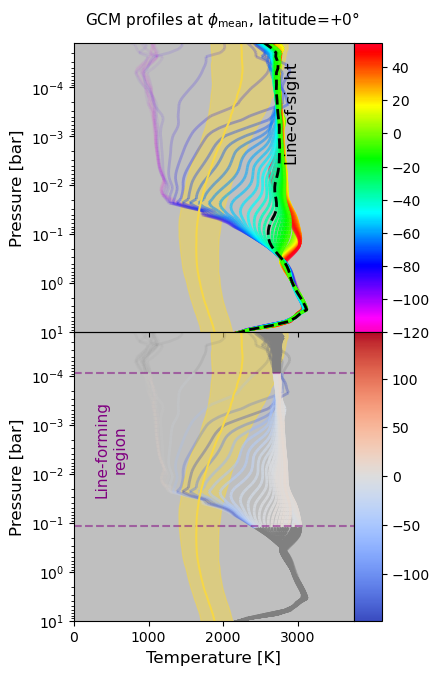

In [11]:
global plot_on_left
plot_on_left = True

phase = 0.59 * 360.
lat = 0.
lf_region = (8.51138038202376e-05, 10**-0.93)
#lf_region = (1e-4, 1e0)

fig, axes = plot_pt_chemistry(P, lats, lat=lat, phase=phase,
                                    lf_region=lf_region,
                                    phase_precision=2, lat_precision=0
                                   )


cmap = colormaps['inferno']
c1 = cmap(0.1)
c2 = cmap(0.9)
dirin_retrieval='../data/pmn_out_3D'
P_retrieved, _, Tlow_1sig, Tmed, Thigh_1sig, _ = pickle.load(open(dirin_retrieval+'/pt_profile.pic', 'rb'))
axes[0].plot(Tmed, P_retrieved, color=c2)
axes[0].fill_betweenx(y=P_retrieved, x1=Tlow_1sig, x2=Thigh_1sig, color=c2, alpha=0.5)
axes[1].plot(Tmed, P_retrieved, color=c2)
axes[1].fill_betweenx(y=P_retrieved, x1=Tlow_1sig, x2=Thigh_1sig, color=c2, alpha=0.5)

if plot_on_left:
    axes[0].set_ylabel('Pressure [bar]', size=12)
    axes[1].set_ylabel('Pressure [bar]', size=12)
axes[1].set_xlabel('Temperature [K]', size=12)

add_label = True
if add_label == True:
    axes[1].annotate('Line-forming\nregion', xy=(500, 10**-2.5), color='purple', rotation=90, fontsize=11, va='center', ha='center')
    axes[0].annotate('Line-of-sight',xy=(2800,10**-2.5), size=12, color='k', rotation=90)

plt.suptitle(r'GCM profiles at '+ r'$\phi_{\rm{mean}}$'+', latitude={:+.{}f}$\degree$'.format(lat, 0), y=0.925, fontsize=11)
if save:
    plt.savefig(dirout+f'Fig7_Panel2_retrieved_1D_versus_longitude_and_line_contrast.png', dpi=250, bbox_inches='tight')
    plt.savefig(dirout+f'Fig7_Panel2_retrieved_1D_versus_longitude_and_line_contrast.pdf', bbox_inches='tight')
plt.show()